# ESN as a feature extractor

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt

# Define ESN class for feature extraction
class ESN(nn.Module):
    def __init__(self, input_size, reservoir_size, output_size, spectral_radius=0.9):
        super(ESN, self).__init__()
        self.input_size = input_size
        self.reservoir_size = reservoir_size

        # Initialize reservoir weights
        self.Win = nn.Parameter(torch.randn(reservoir_size, input_size))
        self.W = nn.Parameter(torch.randn(reservoir_size, reservoir_size))

        # Scaling W to have spectral radius = spectral_radius
        self.W.data *= spectral_radius / torch.max(torch.abs(torch.linalg.eigvals(self.W)))

        # Output layer
        self.Wout = nn.Linear(reservoir_size, output_size)

    def forward(self, input_data, initial_state=None):
        if initial_state is None:
            state = torch.zeros((input_data.size(0), self.reservoir_size)).to(input_data.device)
        else:
            state = initial_state

        state = torch.tanh(torch.matmul(input_data, self.Win.t()) + torch.matmul(state, self.W.t()))
        state = self.Wout(state)
        return state

# Define neural network class for prediction
class SimpleNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Load MNIST data
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Instantiate ESN for feature extraction
input_size = 28*28  # MNIST image size
reservoir_size = 10*input_size  # Size of reservoir
output_size_esn = input_size  # Output size of ESN (features)
esn = ESN(input_size, reservoir_size, output_size_esn)

# Instantiate neural network for prediction
hidden_size = 100
output_size_nn = 10
nn_model = SimpleNN(output_size_esn, hidden_size, output_size_nn)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(nn_model.parameters(), lr=0.001)

100%|██████████| 9912422/9912422 [00:00<00:00, 60116212.44it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 76281923.06it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 32693839.77it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 13084154.37it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [3]:
# Training loop
losses = []
for epoch in range(3):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs = inputs.view(-1, 28*28)  # Flatten images

        optimizer.zero_grad()

        # Feature extraction using ESN
        features = esn(inputs)

        # Forward pass through neural network
        outputs = nn_model(features)

        # Calculate loss
        loss = criterion(outputs, labels)

        # Backward pass
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 100 == 99:
            losses.append(running_loss / 100)
            running_loss = 0.0

In [4]:
print('Losses:', losses)

Losses: [1.017, 0.38, 0.356, 0.328, 0.281, 0.28, 0.257, 0.258, 0.229, 0.192, 0.198, 0.175, 0.179, 0.187, 0.163, 0.179, 0.16, 0.16, 0.119, 0.134, 0.129, 0.126, 0.128, 0.127, 0.117, 0.134, 0.119]


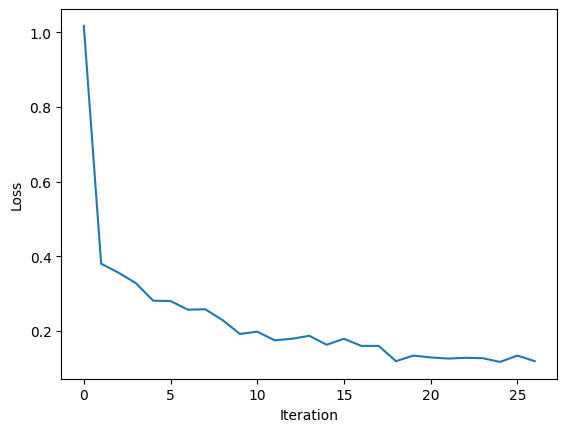

In [5]:
plt.plot(losses)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.show()

In [6]:
# Test the network
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False)

correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.view(-1, 28*28)
        features = esn(images)
        outputs = nn_model(features)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        break

print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))

Accuracy of the network on the 10000 test images: 96 %%


# without ESN

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np

# Define neural network class for prediction
class SimpleNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Load MNIST data
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Instantiate neural network for prediction
input_size = 28*28  # MNIST image size
hidden_size = 100
output_size_nn = 10
nn_model = SimpleNN(input_size, hidden_size, output_size_nn)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(nn_model.parameters(), lr=0.001)

# Training loop
losses = []
for epoch in range(3):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs = inputs.view(-1, 28*28)  # Flatten images

        optimizer.zero_grad()

        # Forward pass through neural network
        outputs = nn_model(inputs)

        # Calculate loss
        loss = criterion(outputs, labels)

        # Backward pass
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 100 == 99:
            losses.append(running_loss / 100)
            running_loss = 0.0

In [8]:
print(losses)

[1.011, 0.464, 0.383, 0.339, 0.311, 0.29, 0.27, 0.259, 0.228, 0.221, 0.176, 0.21, 0.197, 0.181, 0.182, 0.179, 0.173, 0.156, 0.14, 0.149, 0.145, 0.147, 0.129, 0.134, 0.134, 0.135, 0.136]


In [9]:
# Test the network
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False)

correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.view(-1, 28*28)
        outputs = nn_model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))

Accuracy of the network on the 10000 test images: 95 %%
